<a href="https://colab.research.google.com/github/Tamircohen28/baswana-sen-spanner-experiments/blob/main/notebooks/01_baswana_sen_sanity_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baswana-Sen Spanner Sanity Check

This notebook performs sanity checks on the Baswana-Sen algorithm implementation:
- Generate small graphs
- Visualize original graph and spanner
- Verify stretch bounds
- Test on small examples


In [ ]:
# @title
import sys
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path().absolute().parent))

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from src.graphs.erdos_renyi import generate_erdos_renyi_graph
from src.spanners.baswana_sen import build_spanner_baswana_sen
from src.evaluation.stretch import compute_stretch_edges, compute_stretch_sampled_pairs

# Set style
plt.style.use('default')
np.random.seed(42)


## Helper function to convert to NetworkX for visualization


In [ ]:
# @title
def dict_to_networkx(graph_dict):
    """Convert adjacency list to NetworkX graph."""
    G = nx.Graph()
    for u, neighbors in graph_dict.items():
        for v in neighbors:
            if u < v:  # Add each edge once
                G.add_edge(u, v)
    return G


## Test 1: Small graph (n=20, p=0.3)


In [ ]:
# @title
# Generate graph
n = 20
p = 0.3
seed = 42

G_dict, n_orig, n_conn = generate_erdos_renyi_graph(n, p, seed)
print(f"Original vertices: {n_orig}, Connected component: {n_conn}")
print(f"Edges in G: {sum(len(neighbors) for neighbors in G_dict.values()) // 2}")

# Convert to NetworkX for visualization
G_nx = dict_to_networkx(G_dict)
print(f"NetworkX edges: {G_nx.number_of_edges()}")


Original vertices: 20, Connected component: 20
Edges in G: 65
NetworkX edges: 65


In [ ]:
# @title
# Build spanners for different k values
k_values = [1, 2, 3]
results = {}

for k in k_values:
    H_dict = build_spanner_baswana_sen(G_dict, k, seed + 100)
    H_nx = dict_to_networkx(H_dict)

    # Compute stretch
    stretch_info = compute_stretch_edges(G_dict, H_dict)

    results[k] = {
        'H_dict': H_dict,
        'H_nx': H_nx,
        'stretch': stretch_info
    }

    print(f"\nk={k} (spanner stretch bound: {2*k-1}):")
    print(f"  Spanner edges: {H_nx.number_of_edges()}")
    print(f"  Max stretch: {stretch_info['max_stretch']}")
    print(f"  Avg stretch: {stretch_info['avg_stretch']:.3f}")
    print(f"  Stretch bound satisfied: {stretch_info['max_stretch'] <= 2*k-1}")



k=1 (spanner stretch bound: 1):
  Spanner edges: 65
  Max stretch: 1.0
  Avg stretch: 1.000
  Stretch bound satisfied: True

k=2 (spanner stretch bound: 3):
  Spanner edges: 42
  Max stretch: 4.0
  Avg stretch: 1.538
  Stretch bound satisfied: False

k=3 (spanner stretch bound: 5):
  Spanner edges: 40
  Max stretch: 4.0
  Avg stretch: 1.600
  Stretch bound satisfied: True


## Visualize graphs


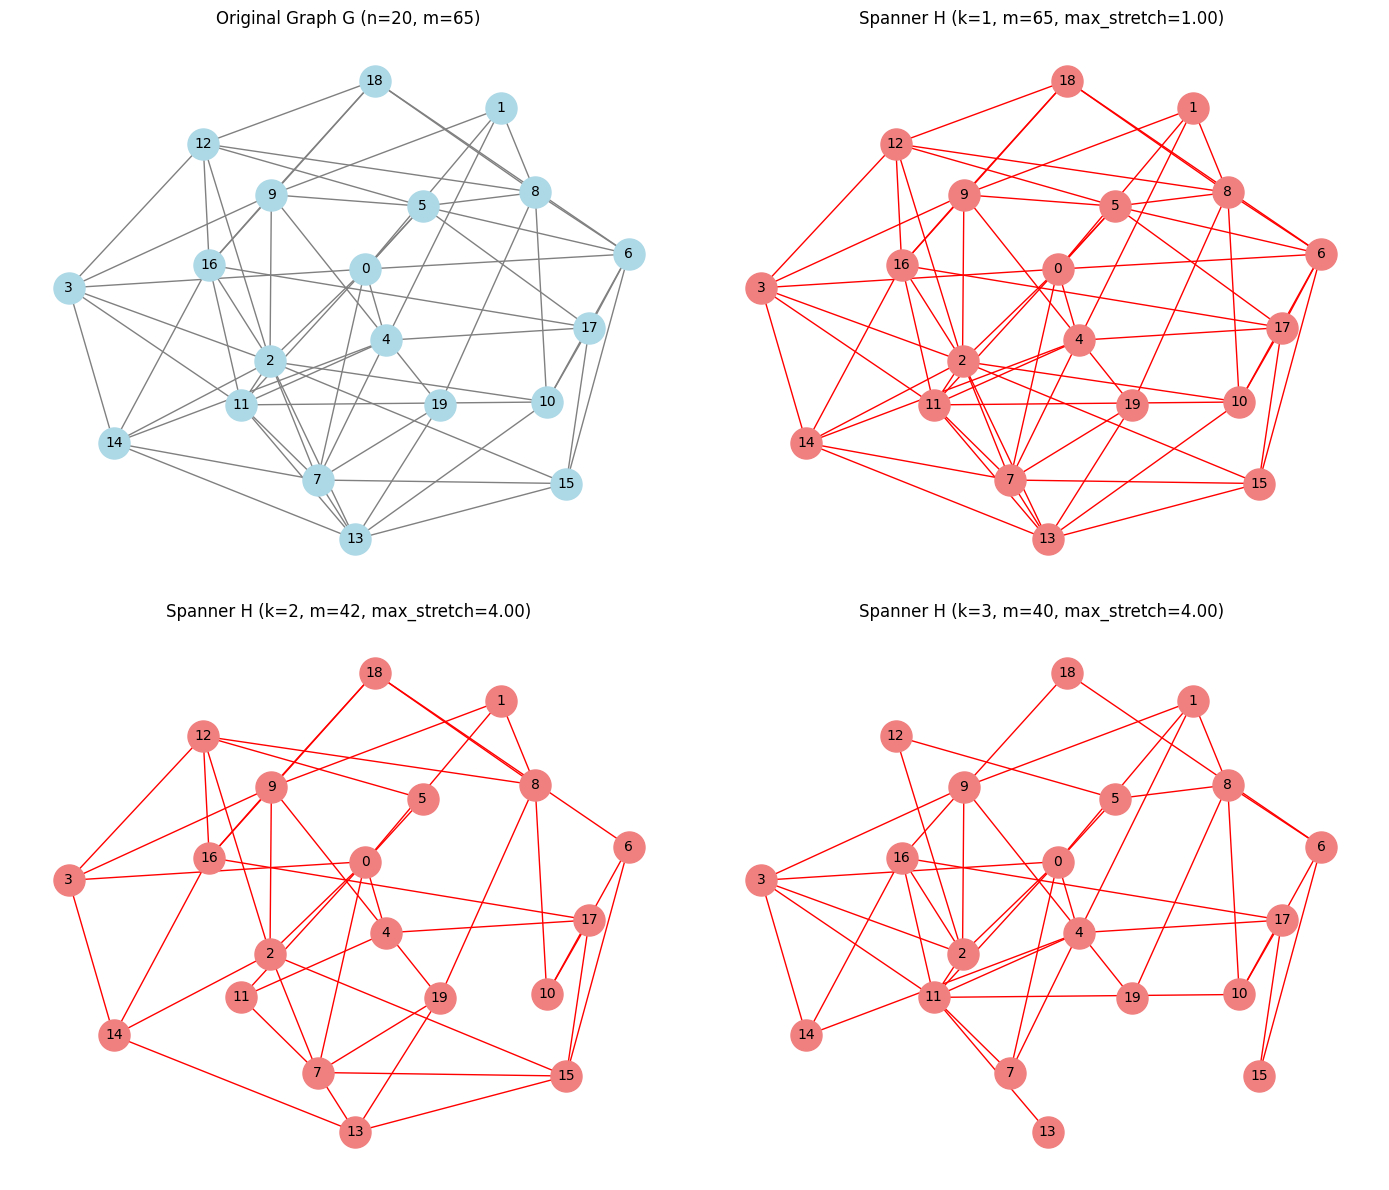

In [ ]:
# @title
# Visualize original graph and spanners
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Original graph
ax = axes[0, 0]
pos = nx.spring_layout(G_nx, seed=42)
nx.draw(G_nx, pos, ax=ax, with_labels=True, node_color='lightblue',
        node_size=500, font_size=10, edge_color='gray')
ax.set_title(f'Original Graph G (n={n_conn}, m={G_nx.number_of_edges()})')

# Spanners for k=1, 2, 3
for idx, k in enumerate([1, 2, 3], start=1):
    ax = axes[idx // 2, idx % 2]
    H_nx = results[k]['H_nx']
    nx.draw(H_nx, pos, ax=ax, with_labels=True, node_color='lightcoral',
            node_size=500, font_size=10, edge_color='red')
    stretch = results[k]['stretch']
    ax.set_title(f'Spanner H (k={k}, m={H_nx.number_of_edges()}, '
                 f'max_stretch={stretch["max_stretch"]:.2f})')

plt.tight_layout()
plt.show()


## Verify stretch bounds


In [ ]:
# @title
# Verify stretch bounds for all k values
print("Stretch verification:")
print("=" * 60)
for k in k_values:
    stretch = results[k]['stretch']
    bound = 2 * k - 1
    satisfied = stretch['max_stretch'] <= bound
    print(f"k={k}: max_stretch={stretch['max_stretch']:.3f}, "
          f"bound={bound}, satisfied={satisfied}")
print("=" * 60)


Stretch verification:
k=1: max_stretch=1.000, bound=1, satisfied=True
k=2: max_stretch=4.000, bound=3, satisfied=False
k=3: max_stretch=4.000, bound=5, satisfied=True


## Test 2: Another small example


In [ ]:
# @title
# Test with different parameters
n2 = 15
p2 = 0.4
seed2 = 123

G2_dict, _, n2_conn = generate_erdos_renyi_graph(n2, p2, seed2)
print(f"Graph 2: n={n2_conn}, m={sum(len(neighbors) for neighbors in G2_dict.values()) // 2}")

k = 2
H2_dict = build_spanner_baswana_sen(G2_dict, k, seed2 + 100)
stretch2 = compute_stretch_edges(G2_dict, H2_dict)

print(f"\nk={k} spanner:")
print(f"  Spanner edges: {sum(len(neighbors) for neighbors in H2_dict.values()) // 2}")
print(f"  Max stretch: {stretch2['max_stretch']}")
print(f"  Avg stretch: {stretch2['avg_stretch']:.3f}")
print(f"  Bound satisfied: {stretch2['max_stretch'] <= 2*k-1}")


Graph 2: n=15, m=41

k=2 spanner:
  Spanner edges: 27
  Max stretch: 4.0
  Avg stretch: 1.585
  Bound satisfied: False


## Test 3: Sampled pairs stretch


In [ ]:
# @title
# Test stretch on sampled pairs
k = 3
H3_dict = build_spanner_baswana_sen(G_dict, k, seed + 200)
stretch_pairs = compute_stretch_sampled_pairs(G_dict, H3_dict, n_samples=1000, seed=seed + 300)

print(f"Sampled pairs stretch (k={k}):")
print(f"  Max stretch: {stretch_pairs['max_stretch']}")
print(f"  Avg stretch: {stretch_pairs['avg_stretch']:.3f}")
print(f"  Number of pairs: {stretch_pairs['n_pairs']}")
print(f"  Bound: {2*k-1}, Satisfied: {stretch_pairs['max_stretch'] <= 2*k-1}")


Sampled pairs stretch (k=3):
  Max stretch: 2.0
  Avg stretch: 1.084
  Number of pairs: 959
  Bound: 5, Satisfied: True
